# Prior Exploration

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import scipy.stats
import seaborn as sns
import ast

Data_path = 'Data/'

## Checking the number of different values in the categorical features 

In [2]:
def number_of_cat(df, col):
    """
    Get the number of unique values in the dictionnaries of the columns col from the data. 
    INPUT
        |---- data [pandas Dataframe] the dataframe with the data 
        |---- col [string array] column name to count unique values
    OUTPUT 
        |---- n [int] number of unique values 
    """
    tmp = df.copy()
    tmp[col] = tmp[col].apply(lambda x : [value['name'] for value in ast.literal_eval(x)])
    tmp = tmp[['title',col]].explode(col)
    return tmp[col].unique().shape[0]

In [3]:
data = pd.read_csv(Data_path+'merged_data.csv',index_col=0)

In [4]:
cat_feat = ['keywords', 'spoken_languages', 'production_companies', 'production_countries', 'genres', 'cast', 'crew']
print('>>> Categorical  features unique values: ')
tot=0
for feat in cat_feat:
    n = number_of_cat(data, feat)
    tot += n
    print(f'\t |----- {feat} : {n}')
print('\t |----------------------------------------------')
print(f'\t |---- Total : {tot}')

>>> Categorical  features unique values: 
	 |----- keywords : 9814
	 |----- spoken_languages : 63
	 |----- production_companies : 5018
	 |----- production_countries : 89
	 |----- genres : 21
	 |----- cast : 54202
	 |----- crew : 52235
	 |----------------------------------------------
	 |---- Total : 121442


## Classes ratio
check the balancing of the classes

In [5]:
# load the features and labels
features_df = pd.read_csv(Data_path+'features.csv',index_col=0)
labels_df = pd.read_csv(Data_path+'labels.csv',index_col=0)
all_df = pd.concat([features_df, labels_df], axis=1)

In [6]:
display(features_df.head())
display(labels_df.head())

,title,budget,popularity,revenue,runtime,vote_average,vote_count,Action,Adventure,Animation,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,avatar,237000000,150.437577,2787965087,162.0,7.2,11800,1,1,0,...,0,0,0,0,0,1,0,0,0,0
1,pirates of the caribbean at worlds end,300000000,139.082615,961000000,169.0,6.9,4500,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,spectre,245000000,107.376788,880674609,148.0,6.3,4466,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,the dark knight rises,250000000,112.312950,1084939099,165.0,7.6,9106,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,john carter,260000000,43.926995,284139100,132.0,6.1,2124,1,1,0,...,0,0,0,0,0,1,0,0,0,0


,title,GoldenGlobes,Nominations_GoldenGlobes,Oscars,Nominations_Oscars,Nominations,Awards
0,avatar,2.0,4.0,3.0,9.0,13.0,5.0
1,pirates of the caribbean at worlds end,0.0,0.0,0.0,2.0,2.0,0.0
2,spectre,1.0,1.0,1.0,1.0,2.0,2.0
3,the dark knight rises,0.0,0.0,0.0,0.0,0.0,0.0
4,john carter,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
def check_balance(df, column):
    """
    return the percentage of non zero value in the column.
    -------
    INPUTS
        |---- df : the pandas.DataFrame where the data is 
        |---- column : the column name to check as a string
    OUTPUTS
        |---- NONE
    """
    pos_count = labels_df[column].value_counts()
    fraction = (np.sum(pos_count) - pos_count[0])/np.sum(pos_count)
    print(f"\t|---- Percentage of movies having one or more {column}: {fraction:.2%}")

In [8]:
print('Oscars ')
check_balance(all_df, 'Nominations_Oscars')
check_balance(all_df, 'Oscars')
print('_'*80)
print('Golden GLobes ')
check_balance(all_df, 'Nominations_GoldenGlobes')
check_balance(all_df, 'GoldenGlobes')
print('_'*80)
print('Oscars + Golden Globes')
check_balance(all_df, 'Nominations')
check_balance(all_df, 'Awards')

Oscars 
	|---- Percentage of movies having one or more Nominations_Oscars: 18.26%
	|---- Percentage of movies having one or more Oscars: 6.93%
________________________________________________________________________________
Golden GLobes 
	|---- Percentage of movies having one or more Nominations_GoldenGlobes: 16.06%
	|---- Percentage of movies having one or more GoldenGlobes: 5.58%
________________________________________________________________________________
Oscars + Golden Globes
	|---- Percentage of movies having one or more Nominations: 22.37%
	|---- Percentage of movies having one or more Awards: 8.60%


# Spearman correlation 

We do not know if our data are linearly related (assumption behind Pearson), that's why we use Spearman coefficient which is a statistical measure of the strength of a monotonic relationship between paired data. <br>
We compute it between awards (or nominations) and budget, popularity, revenue, runtime, vote average, vote count

In [10]:
# compute the spearman correlation coefficients
corr_df = all_df.loc[:,['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'Awards', 'Nominations']] \
                        .corr(method = 'spearman').loc[:,['Awards','Nominations']]
# To remove meaningless information (correlation between labels)
corr_df = corr_df.drop(['Awards','Nominations']) 
corr_df

,Awards,Nominations
budget,0.080653,0.162158
popularity,0.216562,0.297673
revenue,0.228561,0.297307
runtime,0.262652,0.362696
vote_average,0.343199,0.469987
vote_count,0.222532,0.307442


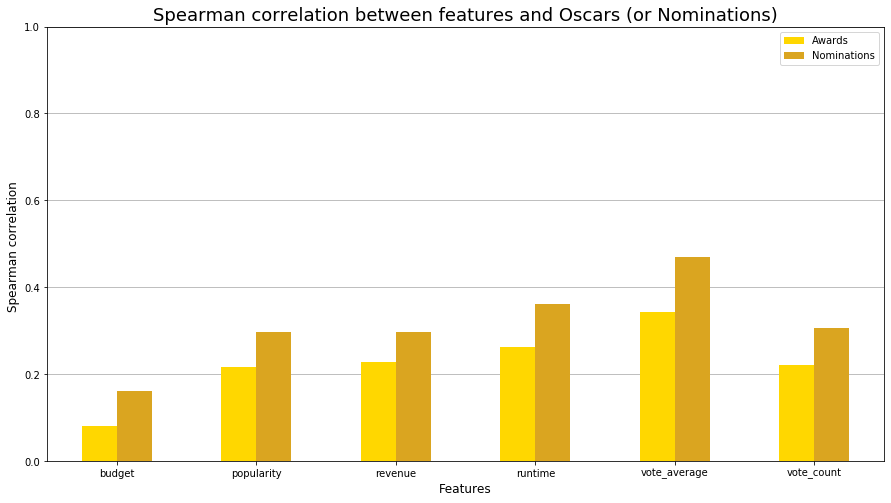

In [11]:
# Bar plots to visualize Spearman correlation
ax = corr_df.plot.bar(rot=0,figsize=(15,8),color=['Gold','Goldenrod'])
ax.set_title("Spearman correlation between features and Oscars (or Nominations)",size=18)
ax.set_ylim([0, 1])
ax.set_xlabel("Features",size=12)
ax.set_ylabel("Spearman correlation ",size=12)
ax.grid(True, which='major', axis='y')
ax.set_axisbelow(True)
plt.show()